In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/web-traffic-time-series-forecasting/sample_submission_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/key_2.csv.zip
/kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip


In [39]:
import warnings

# This code will ignore all warnings
warnings.filterwarnings("ignore")

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt

In [41]:
# Import data
train_df = pd.read_csv("../input/web-traffic-time-series-forecasting/train_2.csv.zip", parse_dates=True)
# train2 = pd.read_csv("../input/web-traffic-time-series-forecasting/train_2.csv.zip", parse_dates=True)

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [43]:
train_data2= train_df
#Get the language of a given page

import re # to separate pages based on language (regular expression)

def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'na'

train_data2['lang'] = train_data2.Page.map(find_language)

In [44]:
#Separate all the pages based on their language and average them up to find views per page per language

lang_sets = {}
lang_sets['en'] = train_data2[train_data2.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train_data2[train_data2.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_data2[train_data2.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_data2[train_data2.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_data2[train_data2.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_data2[train_data2.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_data2[train_data2.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_data2[train_data2.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    print(f"Key: {key}")
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]
    print(lang_sets[key].iloc[:,1:].sum(axis=0))

Key: en
2015-07-01    84712190.0
2015-07-02    84438545.0
2015-07-03    80167728.0
2015-07-04    83463204.0
2015-07-05    86198637.0
                 ...    
2017-09-06    92862934.0
2017-09-07    97701973.0
2017-09-08    74417827.0
2017-09-09    71919663.0
2017-09-10    75370705.0
Length: 803, dtype: float64
Key: ja
2015-07-01    11863200.0
2015-07-02    13620792.0
2015-07-03    12305383.0
2015-07-04    15456239.0
2015-07-05    14827204.0
                 ...    
2017-09-06    11695723.0
2017-09-07    12963373.0
2017-09-08    11691175.0
2017-09-09    12497823.0
2017-09-10    13938056.0
Length: 803, dtype: float64
Key: de
2015-07-01    13260519.0
2015-07-02    13079896.0
2015-07-03    12554042.0
2015-07-04    11520379.0
2015-07-05    13392347.0
                 ...    
2017-09-06    12373349.0
2017-09-07    14257897.0
2017-09-08    11705679.0
2017-09-09    10902535.0
2017-09-10    12183544.0
Length: 803, dtype: float64
Key: na
2015-07-01     1490534.0
2015-07-02     1561810.0
2015-07-0

In [45]:
# # Initialize a dictionary to store sums for each language
# lang_sums = {}

# # Iterate over lang_sets to calculate sums for each language
# for lang, lang_data in lang_sets.items():
#     # Calculate sums for the current language
#     lang_sum = lang_data.iloc[:, 1:].sum(axis=0)
    
#     # Store the sums in lang_sums dictionary
#     lang_sums[lang] = lang_sum

# # Print lang_sums dictionary
# print(lang_sums)

In [46]:
# Get unique keys
unique_keys = list(sums.keys())

# Print unique keys
print("Unique keys in the dictionary:", unique_keys)

Unique keys in the dictionary: ['en', 'ja', 'de', 'na', 'fr', 'zh', 'ru', 'es']


In [47]:
sums

{'en': 2015-07-01    3513.862203
 2015-07-02    3502.511407
 2015-07-03    3325.357889
 2015-07-04    3462.054256
 2015-07-05    3575.520035
                  ...     
 2017-09-06    3851.955119
 2017-09-07    4052.678488
 2017-09-08    3086.851958
 2017-09-09    2983.228099
 2017-09-10    3126.377344
 Length: 803, dtype: float64,
 'ja': 2015-07-01    580.647056
 2015-07-02    666.672801
 2015-07-03    602.289805
 2015-07-04    756.509177
 2015-07-05    725.720914
                  ...    
 2017-09-06    572.449856
 2017-09-07    634.495277
 2017-09-08    572.227253
 2017-09-09    611.708825
 2017-09-10    682.201361
 Length: 803, dtype: float64,
 'de': 2015-07-01    714.968405
 2015-07-02    705.229741
 2015-07-03    676.877231
 2015-07-04    621.145145
 2015-07-05    722.076185
                  ...    
 2017-09-06    667.134793
 2017-09-07    768.744110
 2017-09-08    631.135979
 2017-09-09    587.832803
 2017-09-10    656.901062
 Length: 803, dtype: float64,
 'na': 2015-07-01     8

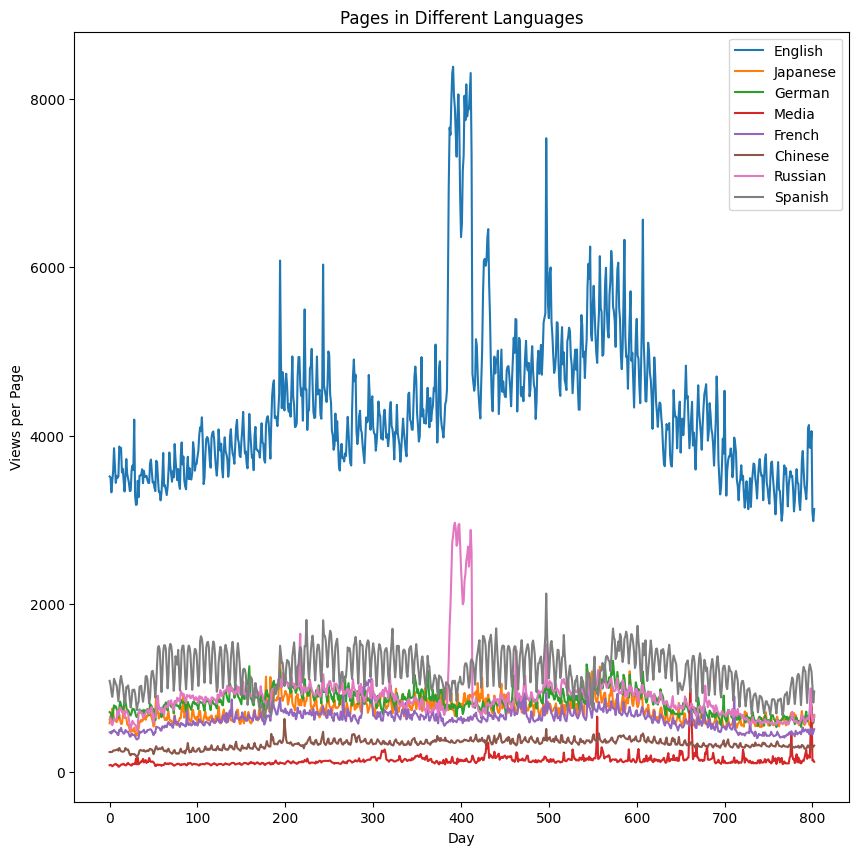

In [48]:
#Plots of average number of views for all different languages per day

days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

In [49]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

In [50]:
def mae(y_true, y_pred):
    """
    Calculate Mean Absolute Error (MAE)
    """
    return np.mean(np.abs(y_true - y_pred)) * 100

In [51]:
# Preprocess data
scaler = MinMaxScaler()
scaled_data = {key: scaler.fit_transform(np.array(sums[key]).reshape(-1, 1)).reshape(-1) for key in sums}


In [52]:
# # Define CNN model
# def create_cnn_model(input_shape):
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(50, activation='relu'))
#     model.add(Dense(1))  # Output layer with 1 neuron for forecasting
#     model.compile(optimizer='adam', loss='mse')
#     return model
from keras.layers import Dropout  # Add this import statement


# Define CNN model with added regularization (dropout)
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # Adding dropout regularization
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # Adding dropout regularization
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  # Output layer with 1 neuron for forecasting
    model.compile(optimizer='adam', loss='mse')
    return model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

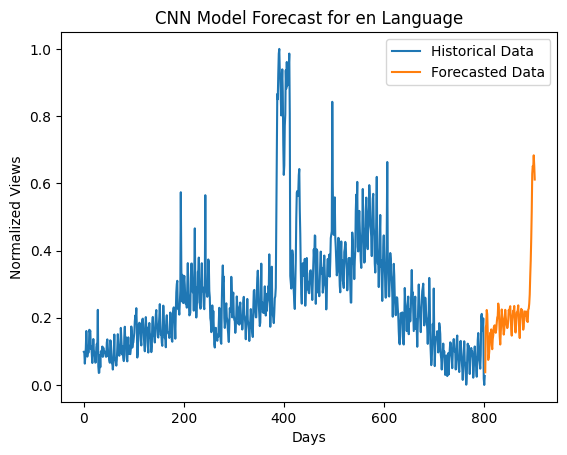

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

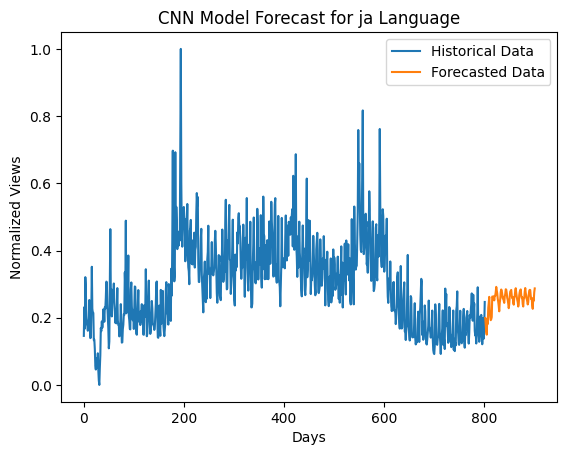

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

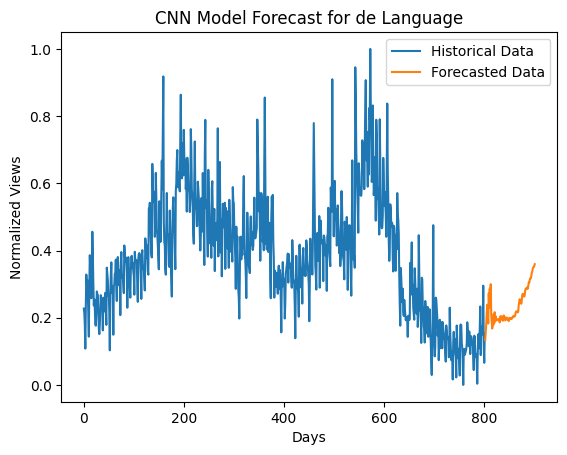

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

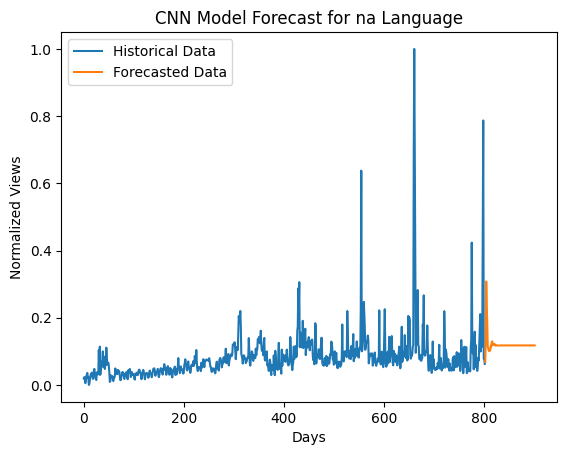

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

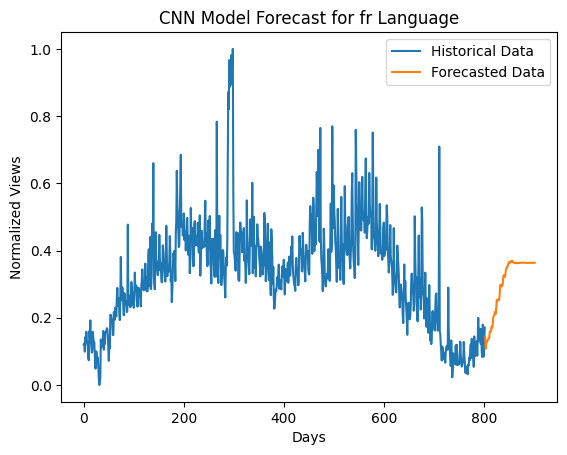

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

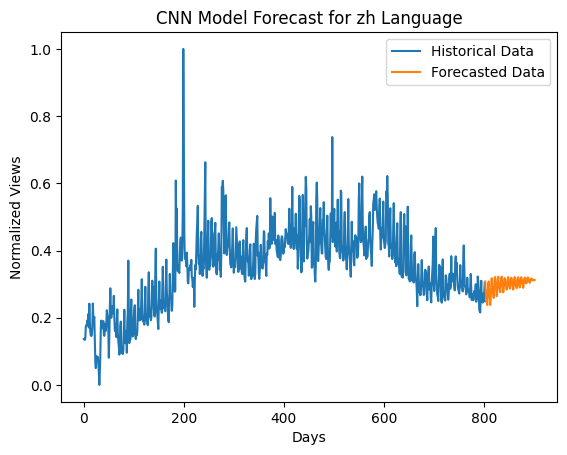

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

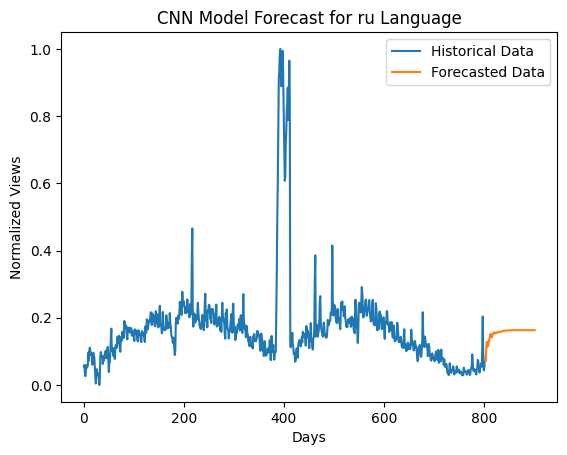

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

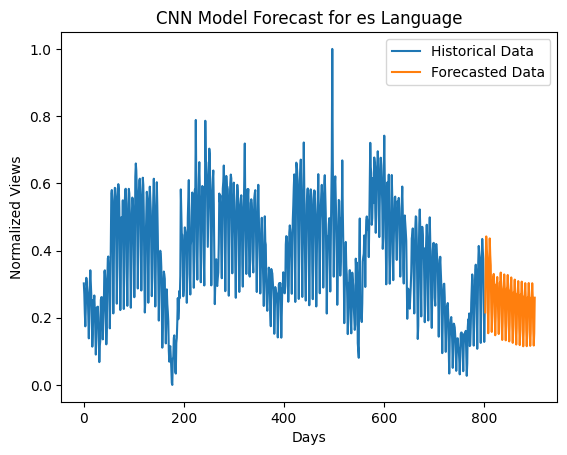

In [55]:
# Train and forecast with CNN model for each language
for key in scaled_data:
    data = scaled_data[key]
    # Assuming window_size is the number of time steps the CNN model will consider at once
    window_size = 10
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for CNN input
    
    # Create and train CNN model
    cnn_model = create_cnn_model((window_size, 1))
    cnn_model.fit(X, y, epochs=1000, batch_size=32, verbose=0)
    
    # Forecast
    forecast = []
    last_sequence = X[-1]
    num_steps = 100  # Number of future steps to forecast
    for _ in range(num_steps):
        pred = cnn_model.predict(last_sequence.reshape(1, window_size, 1))[0, 0]
        forecast.append(pred)
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = pred
    
    # Calculate SMAPE as a percentage
    actual_values = scaler.inverse_transform(data[-num_steps:].reshape(-1, 1)).reshape(-1)
    forecast_values = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).reshape(-1)
    smape_value = smape(actual_values, forecast_values)
    
    # Calculate MAE as a percentage
    mae_value = np.mean(np.abs(actual_values - forecast_values) / actual_values) * 100
 
    # Print SMAPE value
    print(f"SMAPE for {key} Language: {smape_value:.2f}")
    print(f"MAE for {key} Language: {mae_value:.2f}")
    
    
    # Plot results
    plt.plot(data, label='Historical Data')
    plt.plot(range(len(data), len(data) + num_steps), forecast, label='Forecasted Data')
    plt.xlabel('Days')
    plt.ylabel('Normalized Views')
    plt.title(f'CNN Model Forecast for {key} Language')
    plt.legend()
    plt.show()
    


In [ ]:
# # Train and forecast with CNN model for each language
# for key in scaled_data:
#     data = scaled_data[key]
#     # Assuming window_size is the number of time steps the CNN model will consider at once
#     window_size = 10
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         X.append(data[i:i+window_size])
#         y.append(data[i+window_size])
#     X, y = np.array(X), np.array(y)
#     X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for CNN input
    
#     # Create and train CNN model
#     cnn_model = create_cnn_model((window_size, 1))
#     cnn_model.fit(X, y, epochs=100, batch_size=32, verbose=0)
    
#     # Forecast
#     forecast = []
#     last_sequence = X[-1]
#     num_steps = 100  # Number of future steps to forecast
#     for _ in range(num_steps):
#         pred = cnn_model.predict(last_sequence.reshape(1, window_size, 1))[0, 0]
#         forecast.append(pred)
#         last_sequence = np.roll(last_sequence, -1)
#         last_sequence[-1] = pred
    
#     # Calculate SMAPE
#     actual_values = scaler.inverse_transform(data[-num_steps:].reshape(-1, 1)).reshape(-1)
#     forecast_values = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).reshape(-1)
#     smape_value = smape(actual_values, forecast_values)
    
#     # Print SMAPE value
#     print(f"SMAPE for {key} Language: {smape_value:.2f}")
    
    
#     # Plot results
#     plt.plot(data, label='Historical Data')
#     plt.plot(range(len(data), len(data) + num_steps), forecast, label='Forecasted Data')
#     plt.xlabel('Days')
#     plt.ylabel('Normalized Views')
#     plt.title(f'CNN Model Forecast for {key} Language')
#     plt.legend()
#     plt.show()
    
